In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable


In [176]:
class AmznDataLoader():
        def __init__(self):
#            df = self.getDF('./data/reviews_Amazon_Instant_Video_5.json.gz')
#            df = self.getDF('./data/reviews_Musical_Instruments_5.json.gz')
    #         display(self.df)
    #         print(self.df.loc[0][['overall','reviewText']])
                df = self.getDF('./data/reviews_Amazon_Instant_Video_5.json.gz')
    #            df = self.getDF('./data/reviews_Musical_Instruments_5.json.gz')
                df = df[['reviewText', 'overall']]
                df['reviewText'] = df['reviewText'].apply(lambda x : self.title_parsing(x))
                X = df['reviewText']
                y = df['overall']-1
                self.weight_matrix = self.get_weight_matrix(X)
                self.X_train = self.indicesMatrix(X)
                self.y_train= y
               # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            
        def title_parsing(self, title):  
            # remove stop words and tokenization 
            title = re.sub('[^a-zA-Z]', ' ', str(title))
            title = title.lower()
            title = remove_stopwords(title)  ## remove stop words, corpus size 52680            
            title = title.split()
            title = [word for word in title if len(word) >1 ]
            return title
        
        
        def parse(self, path):
            g = gzip.open(path, 'rb')
            for l in g:
                yield eval(l)
            
        def getDF(self, path):
            i = 0
            df = {}
            for d in self.parse(path):
                df[i] = d
                i += 1
            return pd.DataFrame.from_dict(df, orient='index')        

        def buildCorpus(self, X):
            '''
            return a dictionary with 'word' and its index in corpus as key and value respectively
            '''
            word2idx = {}
            idx2word = [] ## alternatively use if.. condition
            idx = 0 
            for row in X:
                for word in row:
                    if word not in word2idx:
                        idx2word.append(word)                
                        word2idx[word] = len(idx2word) 
#             pickle.dump(word2idx, open('./data/corpusDict.txt', 'wb'))
            return word2idx   
        
    
        def indicesMatrix(self, X):
            '''
            return matrix (num_reviews, maxNumberWords) such that review text transformed to index
            '''
            word2idx = self.buildCorpus(X)
#             word2idx = pickle.load(open('./data/corpusDict.txt', 'rb'))
            ## 53008 words in corpus
    
            corpusSize = len(word2idx) 
        
            ###
            k = sorted(len(x) for x in X)
            plt.hist(k)
            ###
            
            
#            maxNumberWords = sorted(len(x) for x in X)[-1]
#            print ("maximum", maxNumberWords)'
            maxNumberWords =60

            index_matrix = np.zeros(( maxNumberWords,X.shape[0]))          
            for i, row in enumerate(X):
                for j, word in enumerate(row):
#                     try:
#                         index_matrix[i,j] = word2idx[word]
#                         words_found += 1
#                     except KeyError:
#                         index_matrix[i,j] = corpusSize     

                    index_matrix[j,i] = word2idx[word]
                    if j >= maxNumberWords -1: 
                        break
#            if maxNumberWords % 2 == 1:
#                x0 = np.full((index_matrix.shape[0], 1), maxNumberWords)
#                index_matrix = np.hstack((index_matrix, x0))
            print(index_matrix.shape)
            return index_matrix
        
        def get_weight_matrix(self, X): #max norm for linear layer
            '''
            return matrix contains embedding for word in corpus/review text
            Note that the word cannot be found in the glove returns ?? as embedding
            '''

            glove = {}

            with open(f'./data/glove.6B.50d.txt', 'rb') as f:#
                for l in f:
                    line = l.decode().split()           
                    word = line[0]
        #            words.append(word)
        #             word2idx[word] = idx
        #            idx += 1
                    vect = np.array(line[1:]).astype(np.float)
        #             vectors.append(vect)
        #     vectors = np.reshape(vectors, (400000, 50))
                    glove.update({word:vect})
        #     glove = {word2idx[w]: vectors[word2idx[w]] for w in words}  # alternatively generate weights_matrix directly

            target_vocab = self.buildCorpus(X)
            #except
            #exceptKey = list(set(list(glove.keys())).difference(list(target_vocab.keys())))  ## 
            matrix_len = len(target_vocab)
            weights_matrix = np.zeros((50,matrix_len+1))#
            words_found = 0
            words_not_found = 0
            for i, word in enumerate(target_vocab):
                try: 
                    weights_matrix[:,i+1] = glove[word]
                    words_found += 1
                except KeyError:
                    words_not_found += 1
                    weights_matrix[:,i+1] = np.random.normal(scale=0.6, size=(50,))#

            print(words_not_found)
            print("w",weights_matrix.shape)
            return  weights_matrix

9776
w (50, 52657)
(60, 37126)


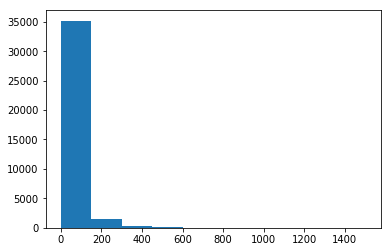

In [177]:
data_loader = AmznDataLoader()

In [162]:
np.count_nonzero(data_loader.X_train)/(data_loader.X_train.shape[0]*data_loader.X_train.shape[1])

0.7834814814814814

In [ ]:
data_loader.X_train.shape
# data_loader.buildCorpus()

In [45]:
weight_matrix = data_loader.weight_matrix
import sys
print(sys.getsizeof(weight_matrix)/(2**20))

# print(weight_matrix[0])
# print(weight_matrix.shape)

5.102264404296875


In [12]:
pickle.dump(weight_matrix,  open('./data/GloveMatrix.npy', 'wb'))

In [15]:
from collections import Counter
c = Counter(data_loader.y_train)

In [16]:
[(i, c[i]/len(data_loader.y_train)*100) for i in c]

[(4.0, 67.49512670565302),
 (2.0, 7.69980506822612),
 (3.0, 20.382553606237817),
 (0.0, 2.022417153996101),
 (1.0, 2.4000974658869394)]

In [17]:
weight = Variable(torch.cuda.FloatTensor([0.4,0.5,0.11,0.23,0.56])) 

In [6]:
from skorch.callbacks import EpochScoring, PrintLog, ProgressBar, LRScheduler, EarlyStopping

In [191]:
# todo reset parameters for linear layer
class ReviewModel(nn.Module):
    def __init__(self, max_length, batch_size):
        super(ReviewModel, self).__init__()
        weights_matrix = data_loader.weight_matrix.T
        self.max_length = max_length
        self.batch_size = batch_size
        self.embed_size = weights_matrix.shape[0]
        
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix), freeze=False)
        self.drop1 = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv1d(in_channels=self.embed_size, out_channels=200, kernel_size=4, padding=2).double()#
        self.conv2 = nn.Conv1d(in_channels=self.embed_size, out_channels=200, kernel_size=5, padding=2).double()#
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.drop2 = nn.Dropout(p=0.3)
        self.rnn = nn.GRU(input_size=400, hidden_size=100, num_layers=1, batch_first=False) 
        self.fc1 =nn.Linear(in_features=(max_length//2)*100, out_features = 400)
        max_norm(self.fc1)
        self.drop3 = nn.Dropout(p=0.15)
        self.fc2 = nn.Linear(in_features=400, out_features=5)
        
    def forward(self, x):
        # x_size = (batch_size, max_seq_len)
        x = self.embedding(x)
        
        # x_size = (batch_size, max_seq_len, embed_size)
        x = self.drop1(x)
        print(x.size())
        #x = x.view(-1,self.embed_size,self.max_length)  
        # x_size = (batch_size,embed_size,max_seq_len) 
        
        x1 = F.relu(self.conv1(x))
        
        x2 = F.relu(self.conv2(x))
        # x1_size = (batch_size, 200, max_seq_len+1)
        # x2_size = (batch_size, 200, max_seq_len)

        x1 = self.maxpool(x1)
        
        x2 = self.maxpool(x2)
        # x1_size = x2_size = (batch_size,200, max_seq_len//2)

        x = torch.cat((x1,x2), 2)
        # x_size = (batch_size, 400, max_seq_len//2)
        print("cat",x.size())
        x = self.drop2(x)
        
        # x = x.view((self.max_length//2),-1, 400).float()
        # x_size = (max_seq_len//2, batch_size, 400)

        hidden = Variable(torch.cuda.FloatTensor(1, batch_size, 100).uniform_()) 
        output, _ = self.rnn(x,hidden)
        # output_size = (max_seq_len//2, batch_size, hidden_size)

        x = output.contiguous().view(self.batch_size,-1)
        # x_size = (batch_size, max_seq_len//2 *hidden_size)

        x = F.relu(self.fc1(x))
        # x_size = (batch_size, 400)
        
        x = self.drop3(x)
        
        x = self.fc2(x)
        # x_size = (batch_size, out_dim)
        return x

In [181]:
# todo reset parameters for linear layer
class SimpleModel(nn.Module):
    def __init__(self, max_length, batch_size):
        super(SimpleModel, self).__init__()
        weights_matrix = data_loader.weight_matrix
        self.max_length = max_length
        self.batch_size = batch_size
        self.embedding = X.shape[0](torch.tensor(weights_matrix), freeze=False)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=100, 
                                              kernel_size=(fs,50)).double() for fs in [2,3,4]])
        self.fc = nn.Linear(3*100,2)
        self.dropout = nn.Dropout(0.5)


        
    def forward(self, x):
        x = x.view(-1, self.batch_size)
        x = x.permute(1,0)
#         print("input 1tensor", x.size())
        x = self.embedding(x)
        x = x.unsqueeze(1)
        conved = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(conv,conv.shape[2]).squeeze(2).float() for conv in conved]
        x = self.dropout(torch.cat(x, dim = 1))
        x = self.fc(x)
        return x

In [139]:
def max_norm(model, max_val=3, eps=1e-8):
    for name, param in model.named_parameters():
        if 'bias' not in name:
            norm = param.norm(2, dim=0, keepdim=True)
            desired = torch.clamp(norm, 0, max_val)
            param = param * (desired / (eps + norm))

In [192]:
callbacks = [
    ('es1',EpochScoring('accuracy')),
    ('lrs',LRScheduler()),
    ('est',EarlyStopping()),
    
]

            
batch_size = 128
device = torch.device("cuda")
max_length = 60
#model = DynamicModel(max_length = max_length, batch_size = batch_size, parameter_dict=SST2_DATASET_PARAMETERS).to(device)
#model = SimpleModel(max_length, batch_size = batch_size).to(device)
model = ReviewModel(max_length, batch_size).to(device)

# net = NeuralNetClassifier(model,## change dimensionality
#                           iterator_train__drop_last = True,
#                           iterator_valid__drop_last = True, 
#                           iterator_train__shuffle = True,
#                           iterator_valid__shuffle = True,
#                           max_epochs=100, 
#                           criterion = nn.CrossEntropyLoss, 
#                           #criterion__weight = weight, 
#                           optimizer=optim.Adagrad,
#                           lr = 0.01,
#                           #optimizer_param_groups = [('momentum',0.5)],
#                           #optimizer__param_groups =[('eps', 1e-6)],  ## review model , sgd, lr = 0.01, m = 0,5
#                           batch_size = batch_size,
#                           callbacks = callbacks,
#                           device = device,verbose = 1
#                           )

net = NeuralNetClassifier(model,## change dimensionality
                          iterator_train__drop_last = True,
                          iterator_valid__drop_last = True, 
                          iterator_train__shuffle = True,
                          iterator_valid__shuffle = True,
                          max_epochs=100, 
                          criterion = nn.CroessEntropyLoss, 
                          #criterion__weight = weight, 
                          optimizer=optim.Adagrad,
                          lr = 0.01,
                          #optimizer_param_groups = [('eps',1e-6)],
                          #optimizer__param_groups =[('eps', 1e-6)],  ## review model , sgd, lr = 0.01, m = 0,5
                          batch_size = batch_size,
                          callbacks = callbacks,
                          device = device,verbose = 1
                          )

RuntimeError: CUDA error: device-side assert triggered

In [189]:
inputs = torch.from_numpy(data_loader.X_train).long().to(device)
labels = torch.tensor(data_loader.y_train.values).long().to(device)
# rest = inputs.size()[0] % batch_sizen_filters]
# print(rest)
# print(inputs.size())
# inputs = inputs[:-rest]
# print(inputs.size()[0]/batch_size)
# print(inputs.shape)
# labels = labels[:-rest]
net.fit(inputs, labels)

RuntimeError: CUDA error: device-side assert triggered

In [190]:
data_loader.X_train.shape

(60, 37126)

In [ ]:
# save model
with open("model.pkl", 'wb') as f:
    pickle.dump("model",f)
    
    

In [ ]:
with open("model.pkl","rb") as f: 
    model = pickle.load(f)

In [ ]:
# m = data_loader.indicesMatrix()
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [ ]:
import matplotlib.pyplot as plt
def plot_losses(tr_loss, val_loss):
    plt.plot(tr_loss, label="training")
    plt.plot(val_loss, label="validation")
    plt.legend()
    plt.show()

In [ ]:
#todo plot losses
#todo plot accuracy
#todo confusion matrix
history = net.history
train_losses = history[:, 'train_loss']
valid_losses = history[:, 'valid_loss']

accuracy = history[:, 'accuracy']
plot_losses(train_losses, valid_losses)

In [ ]:
torch.cuda.empty_cache()

In [25]:
# from sklearn.model_selection import GridSearchCV

In [21]:
# params = {
#     'lr': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
#     'max_epochs': list(range(10,100,20))
# }
# gs = GridSearchCV(net, params, refit = False, scoring = 'accuracy',verbose = 1)


In [15]:
from collections import Counter
c = Counter(data_loader.y_train)

In [16]:
[(i, c[i]/len(data_loader.y_train)*100) for i in c]

[(4.0, 67.49512670565302),
 (2.0, 7.69980506822612),
 (3.0, 20.382553606237817),
 (0.0, 2.022417153996101),
 (1.0, 2.4000974658869394)]

In [17]:
weight = Variable(torch.cuda.FloatTensor([0.4,0.5,0.11,0.23,0.56])) 

In [7]:
from skorch.callbacks import EpochScoring, PrintLog, ProgressBar, LRScheduler, EarlyStopping
from sklearn.metrics import accuracy_score,make_scorer

In [79]:
SST2_DATASET_PARAMETERS = {
    "cell_one_parameter_dict" : {
        "sent_length": 19,
        "conv_kernel_size": (7, 1),
        "conv_input_channels": 1,
        "conv_output_channels": 6,
        "conv_stride": (1, 1),
        "k_max_number": 10,
        "folding_kernel_size": (1, 2),
        "folding_stride": (1, 2)
    },
    "cell_two_parameter_dict" : {
        "sent_length": None,
        "conv_kernel_size": (5, 1),
        "conv_input_channels": 6,
        "conv_output_channels": 14,
        "conv_stride": (1, 1),
        "k_max_number": 4,
        "folding_kernel_size": (1, 2),
        "folding_stride": (1, 2)
    },
    "dropout_rate": 0.5,
    "embedding_dim": 50,
    "vocab_length": data_loader.weight_matrix,
    "output_dim": 2
}
SST2_DATASET_PARAMETERS["cell_two_parameter_dict"]["sent_length"] = SST2_DATASET_PARAMETERS["cell_one_parameter_dict"]["k_max_number"]

In [88]:

# todo reset parameters for linear layer
class DynamicModel(nn.Module):
    def __init__(self, max_length, batch_size,parameter_dict):
        super().__init__()
        self.parameter_dict = parameter_dict
        weights_matrix = data_loader.weight_matrix
        self.max_length = max_length
        self.batch_size = batch_size
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix), freeze=False)
        self.dcnn_first_cell = DCNNCell(
            cell_number=-1,
            sent_length=self.parameter_dict["cell_one_parameter_dict"]["sent_length"],
            conv_kernel_size=self.parameter_dict["cell_one_parameter_dict"]["conv_kernel_size"],
            conv_input_channels=self.parameter_dict["cell_one_parameter_dict"]["conv_input_channels"],
            conv_output_channels=self.parameter_dict["cell_one_parameter_dict"]["conv_output_channels"],
            conv_stride=self.parameter_dict["cell_one_parameter_dict"]["conv_stride"],
            k_max_number=self.parameter_dict["cell_one_parameter_dict"]["k_max_number"],
            folding_kernel_size=self.parameter_dict["cell_one_parameter_dict"]["folding_kernel_size"],
            folding_stride=self.parameter_dict["cell_one_parameter_dict"]["folding_stride"],
        ).double()
        self.dcnn_last_cell = DCNNCell(
            cell_number=-1,
            sent_length=self.parameter_dict["cell_two_parameter_dict"]["sent_length"],
            conv_kernel_size=self.parameter_dict["cell_two_parameter_dict"]["conv_kernel_size"],
            conv_input_channels=self.parameter_dict["cell_two_parameter_dict"]["conv_input_channels"],
            conv_output_channels=self.parameter_dict["cell_two_parameter_dict"]["conv_output_channels"],
            conv_stride=self.parameter_dict["cell_two_parameter_dict"]["conv_stride"],
            k_max_number=self.parameter_dict["cell_two_parameter_dict"]["k_max_number"],
            folding_kernel_size=self.parameter_dict["cell_two_parameter_dict"]["folding_kernel_size"],
            folding_stride=self.parameter_dict["cell_two_parameter_dict"]["folding_stride"],
        )  .double()      
        self.fc_layer_input = self.parameter_dict["cell_two_parameter_dict"]["k_max_number"] *\
            self.parameter_dict["cell_two_parameter_dict"]["conv_output_channels"] *\
            math.floor(self.parameter_dict["embedding_dim"]/4)
            
        self.dropout = nn.Dropout(self.parameter_dict["dropout_rate"])
        self.flatten = Flatten()
        self.fc = nn.Linear(self.fc_layer_input, self.parameter_dict["output_dim"])
        
    def forward(self, inp):
        # [batch_size, sent_length]
        embedded = self.embedding(inp)
        #print(embedded.size())
        # [batch_size, sent_length, embedding_dim]
        # adding single channel dimension
        embedded = embedded.unsqueeze(1)
        # print(embedded.shape)
        # [batch_size, 1(initial_input_channel), sent_length, embedding_dim]
        out = torch.tanh(self.dcnn_first_cell(embedded))
        # print(out.shape)
        # [batch_size, first_cell_output_channels, first_cell_k_maxed_number, embedding_dim]
        out = torch.tanh(self.dcnn_last_cell(out))
        # print(out.shape)
        # [batch_size, last_cell_output_channels, last_cell_k_maxed_number, embedding_dim/2]
        out = self.dropout(self.flatten(out)).float()
        # print(flat.shape)
        #[batch_size, last_cell_output_channels * last_cell_k_maxed_number * embedding_dim/2]
        out = self.fc(out)
        # print(fc.shape)
        return out

In [150]:
path = './data/reviews_Amazon_Instant_Video_5.json.gz'
".txt" in path

False

In [85]:
class DCNNCell(nn.Module):
    def __init__(
        self,
        cell_number=1,
        sent_length=7,
        conv_kernel_size=(3, 1),
        conv_input_channels=1,
        conv_output_channels=2,
        conv_stride=(1, 1),
        k_max_number=5,
        folding_kernel_size=(1, 2),
        folding_stride=(1,1)
    ):
        super().__init__()
        self.cell_number=cell_number 
        self.sent_length=sent_length
        self.conv_kernel_size=conv_kernel_size
        self.conv_input_channels=conv_input_channels
        self.conv_output_channels=conv_output_channels
        self.conv_stride=conv_stride
        self.k_max_number=k_max_number
        self.folding_kernel_size=folding_kernel_size
        self.folding_stride=folding_stride
        
        # calculating padding size
        self.pad_0_direction = math.ceil(self.conv_kernel_size[0] - 1)
        self.pad_1_direction = math.ceil(self.conv_kernel_size[1] - 1)
        
        # 2d convolution
        self.conv_layer = nn.Conv2d(
            in_channels=self.conv_input_channels,
            out_channels=self.conv_output_channels,
            kernel_size=self.conv_kernel_size,
            stride=self.conv_stride,
            padding=(self.pad_0_direction, self.pad_1_direction)
        )
        
        # if cell is last then initialising folding
        if cell_number == -1:
            self.fold = nn.AvgPool2d(kernel_size=self.folding_kernel_siz§e, stride=self.folding_stride)
            
    def forward(self, inp):
        
        # [batch_size, input_channels, sent_length_in, embedding_dim]
        conved = self.conv_layer(inp)
        
        # [batch_size, out_channels, sent_length_out, embedding_dim]
        if self.cell_number == -1:
            conved = self.fold(conved)
        
        # [batch_size, out_channels, sent_length, embedding_dim/2]
        k_maxed = torch.topk(conved, self.k_max_number, dim=2, largest=True)[0]
        
        # [batch_size, out_channels, k_maxed_number, embedding_dim/2]
        return k_maxed

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [ ]:
'./data/reviews_Amazon_Instant_Video_5.json.gz'
